In [2]:
import sys
import os
# Add the project root directory to Python path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
from simulator.motor import Motor
from simulator.state import MotorHiddenState
from simulator.config import DEFAULT_CONFIG

state = MotorHiddenState(
    bearing_health=1.0,
    load_factor=1.2,
    misalignment=0.1,
    friction_coeff=DEFAULT_CONFIG["base_friction"]
)

motor = Motor(state, DEFAULT_CONFIG)

records = []

for t in range(3000):
    sensors = motor.step()
    sensors["time"] = t
    records.append(sensors)

df = pd.DataFrame(records)
df

,temperature,vibration,current,rpm,bearing_health,time
0,25.068985,0.577836,12.290256,1788.993842,0.999868,0
1,25.388533,0.618639,12.036276,1793.549523,0.999736,1
2,24.264599,0.795208,11.803121,1769.945052,0.999604,2
3,25.085930,0.966643,12.417595,1784.050377,0.999472,3
4,25.467185,0.901763,12.215192,1797.575705,0.999340,4
...,...,...,...,...,...,...
2995,27.829473,2.457934,18.617879,1795.210975,0.604528,2995
2996,28.651736,2.135950,17.706268,1797.000857,0.604396,2996
2997,28.035757,2.229022,17.931891,1790.008933,0.604264,2997
2998,27.811407,2.351199,17.698568,1789.865321,0.604132,2998


In [2]:
df.isna().sum()


temperature       29
vibration         34
current           24
rpm               20
bearing_health     0
time               0
dtype: int64

# Checking the sanity of the data

In [3]:
import matplotlib.pyplot as plt


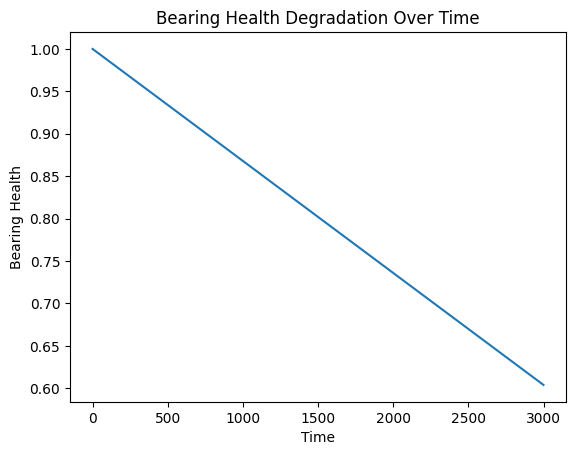

In [10]:
plt.figure()
plt.plot(df["time"], df["bearing_health"])
plt.xlabel("Time")
plt.ylabel("Bearing Health")
plt.title("Bearing Health Degradation Over Time")
plt.show()


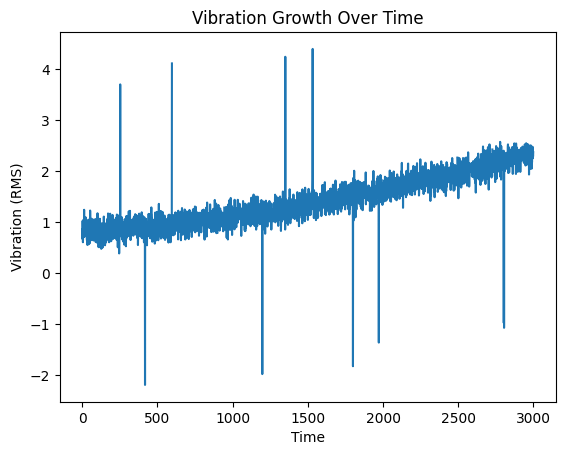

In [5]:
plt.figure()
plt.plot(df["time"], df["vibration"])
plt.xlabel("Time")
plt.ylabel("Vibration (RMS)")
plt.title("Vibration Growth Over Time")
plt.show()


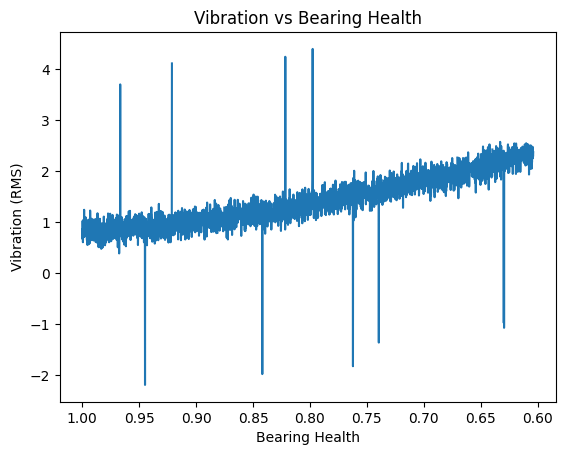

In [6]:
plt.figure()
plt.plot(df["bearing_health"], df["vibration"])
plt.xlabel("Bearing Health")
plt.ylabel("Vibration (RMS)")
plt.title("Vibration vs Bearing Health")
plt.gca().invert_xaxis()  # optional: healthy → failed (left to right)
plt.show()


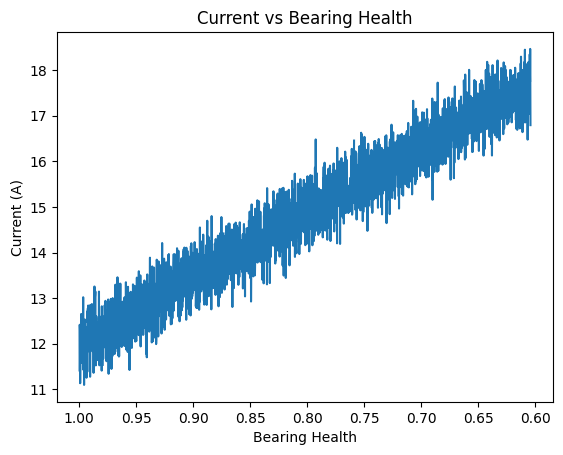

In [7]:
plt.figure()
plt.plot(df["bearing_health"], df["current"])
plt.xlabel("Bearing Health")
plt.ylabel("Current (A)")
plt.title("Current vs Bearing Health")
plt.gca().invert_xaxis()
plt.show()


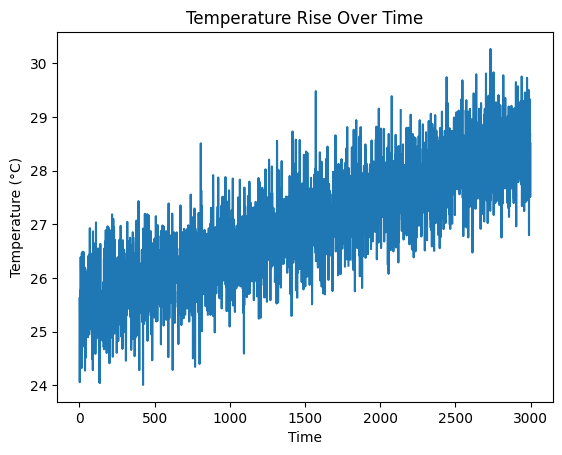

In [8]:
plt.figure()
plt.plot(df["time"], df["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Rise Over Time")
plt.show()


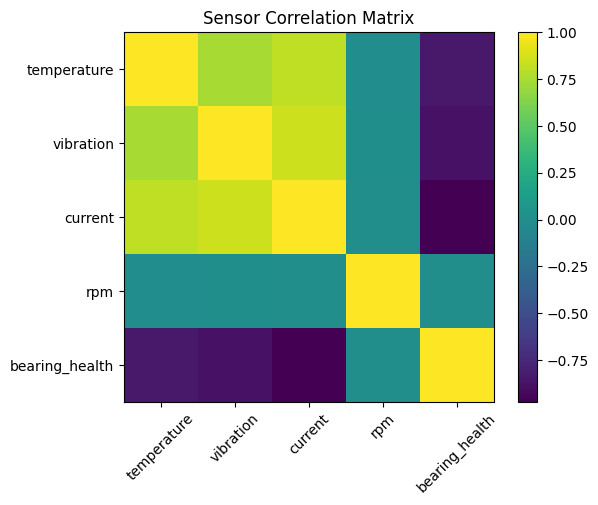

In [9]:
import numpy as np

corr = df[["temperature", "vibration", "current", "rpm", "bearing_health"]].corr()

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Sensor Correlation Matrix")
plt.show()


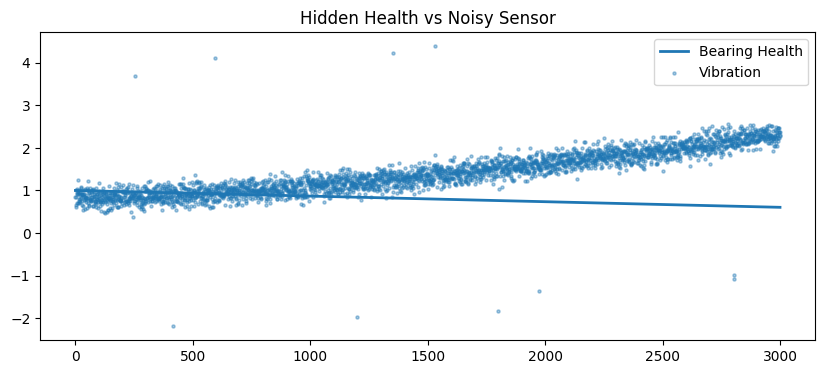

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["time"], df["bearing_health"], label="Bearing Health", linewidth=2)
plt.scatter(df["time"], df["vibration"], s=5, alpha=0.4, label="Vibration")
plt.legend()
plt.title("Hidden Health vs Noisy Sensor")
plt.show()


In [10]:
import pandas as pd
from simulator.factory import FactorySimulator
from simulator.config_realistic import REALISTIC_CONFIG

factory = FactorySimulator(
    num_motors=5,
    base_config=REALISTIC_CONFIG
)

records = []

for t in range(300):
    step_records = factory.step()
    records.extend(step_records)

df = pd.DataFrame(records)
df.head()


,temperature,vibration,current,rpm,bearing_health,time,motor_id
0,25.193102,0.470684,9.046336,1805.017867,0.995950,0,0
1,25.056502,0.599892,10.043687,1802.747599,0.994722,0,1
2,25.062065,0.574542,10.886332,1797.122411,0.993308,0,2
3,25.216546,0.610386,12.042395,1796.162465,0.991700,0,3
4,25.176987,0.660475,13.039951,1791.292811,0.989891,0,4


In [11]:
df.groupby("motor_id")["bearing_health"].last()


motor_id
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: bearing_health, dtype: float64

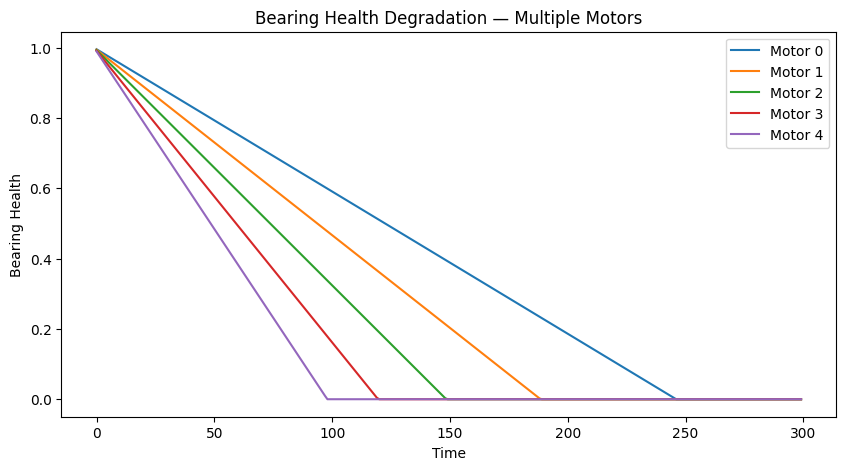

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for motor_id in df["motor_id"].unique():
    subset = df[df["motor_id"] == motor_id]
    plt.plot(subset["time"], subset["bearing_health"], label=f"Motor {motor_id}")

plt.xlabel("Time")
plt.ylabel("Bearing Health")
plt.title("Bearing Health Degradation — Multiple Motors")
plt.legend()
plt.show()


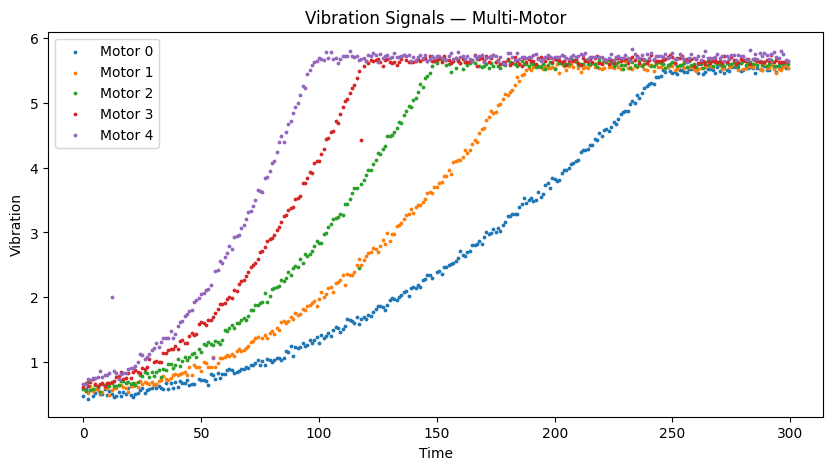

In [13]:
plt.figure(figsize=(10,5))

for motor_id in df["motor_id"].unique():
    subset = df[df["motor_id"] == motor_id]
    plt.scatter(subset["time"], subset["vibration"], s=3, label=f"Motor {motor_id}")

plt.xlabel("Time")
plt.ylabel("Vibration")
plt.title("Vibration Signals — Multi-Motor")
plt.legend()
plt.show()
